## Import Libraries

In [33]:
import librosa
import librosa.display
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')


import pandas as pd
import os
import IPython.display as ipd 
import pickle
import numpy
import csv
import scipy.misc
import scipy
from scipy import ndimage
import cv2
from keras.preprocessing.image import ImageDataGenerator

## Loading in Audio DataFrame + Cleaning

In [21]:
df = pd.read_csv('../data/Emotional_audio_df.csv')

In [22]:
emotion = []
gender = []

for i in df.labels.values:
    gender.append(i.split('_')[0])
    
for i in df.labels.values:
    emotion.append((i.split('_')[-1]))
    
df['gender'] = gender    
df['emotion'] = emotion

df = df.drop('labels', axis = 1)
df = df[['gender','emotion','source','path']]

df = df[df['emotion'] != 'Unknown']

## Audio EDA

In [23]:
emotion_count = pd.DataFrame(df.groupby('emotion').count()['gender']).reset_index()

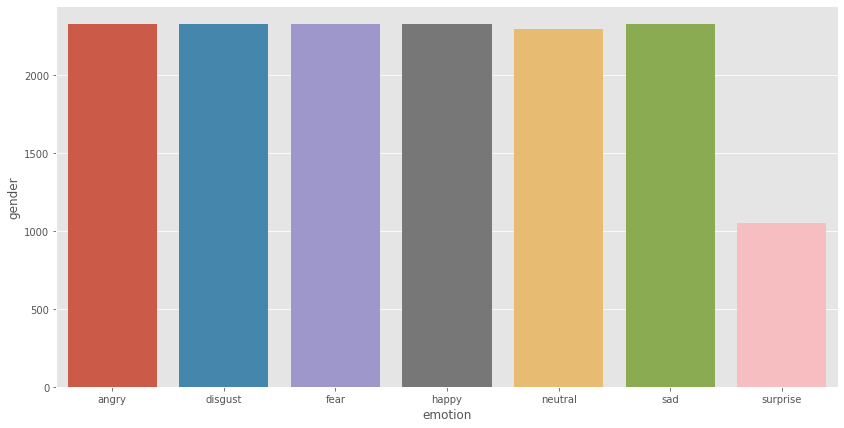

In [25]:
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = emotion_count.emotion, y = emotion_count.gender)

In [27]:
gender_count = pd.DataFrame(df.groupby('gender').count()['emotion']).reset_index()

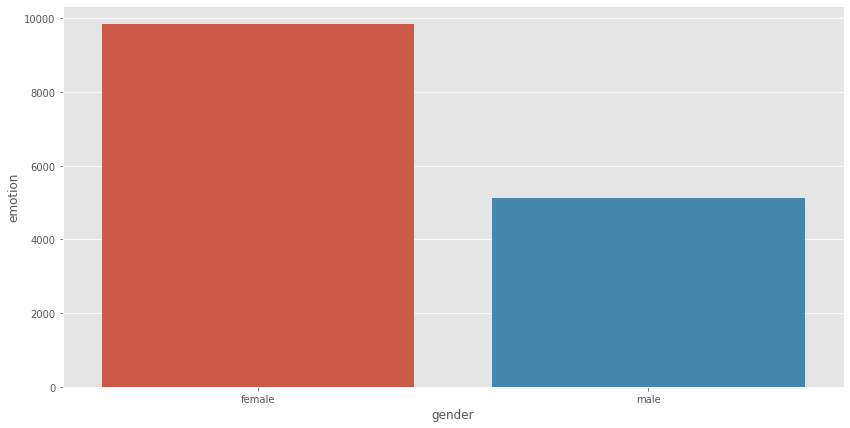

In [28]:
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = gender_count.gender, y = gender_count.emotion)

In [29]:
data_source_count = pd.DataFrame(df.groupby('source').count()['gender']).reset_index()

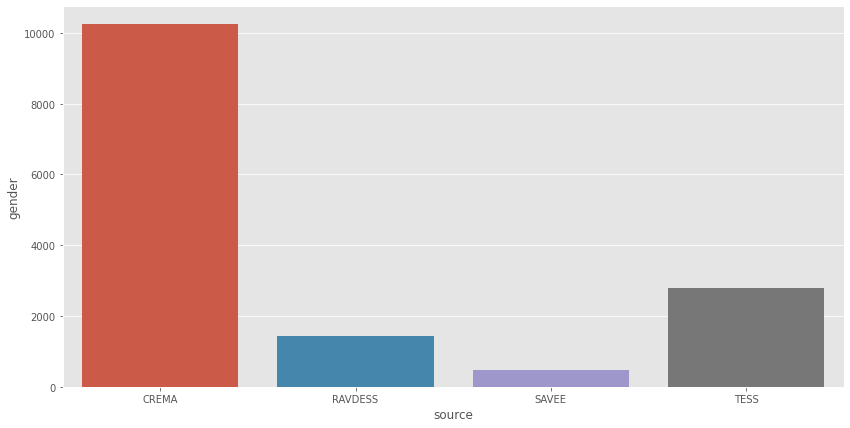

In [30]:
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = data_source_count.source, y = data_source_count.gender)

In [31]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) 
    Y = abs(np.fft.rfft(y)/n) #magnitude -- also /n so that it normalizes/scales the signal
    return (Y, freq)


def frequencies(df):
    signals = {}
    fft = {}
    fbank = {}
    mfccs = {}
    emotion = 'happy sad angry neutral surprised fearful disgust'
    for i in emotion.split(' '):
        wav_file = df[df['emotion'] == i].iloc[0,0]
        signal, rate = librosa.load(wav_file, mono=True, duration=3, offset = .5) #wav file can detect sampling rate
        signals[i] = signal
        fft[i] = calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T #nfft=sampling_frequency/40, nfilt always 26
        fbank[i] = bank
        mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T #numcep = usually 1/2 of nfilt
        mfccs[i] = mel
    return signals, fft, fbank, mfccs

In [39]:
df[df['gender'] == 'male']

,gender,emotion,source,path
0,male,angry,SAVEE,../data/SAVEE/DC_a03.wav
1,male,neutral,SAVEE,../data/SAVEE/KL_n21.wav
2,male,surprise,SAVEE,../data/SAVEE/KL_su12.wav
3,male,angry,SAVEE,../data/SAVEE/JK_a11.wav
4,male,neutral,SAVEE,../data/SAVEE/JE_n07.wav
...,...,...,...,...
14903,male,disgust,CREMA,../data/AudioWAV/1090_WSI_DIS_XX.wav
14904,male,fear,CREMA,../data/AudioWAV/1090_WSI_FEA_XX.wav
14905,male,happy,CREMA,../data/AudioWAV/1090_WSI_HAP_XX.wav
14906,male,neutral,CREMA,../data/AudioWAV/1090_WSI_NEU_XX.wav


In [45]:
female_audio = df[df['gender'] == 'female']
male_audio = df[df['gender'] == 'male']

In [55]:
male_audio[male_audio['source'] == 'RAVDESS'].path.values[0]

'../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-01-01.wav'

In [56]:
male_dict = {
'neutral' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav',
'happy' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-03-02-01-02-01.wav',
'sad' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-02-01.wav',
'angry' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-05-02-01-02-01.wav',
'fearful' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-06-02-01-02-01.wav',
'disgust' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-07-02-01-02-01.wav',
'surprised' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-08-02-01-02-01.wav',
}

female_dict = {
'neutral' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-02-02.wav',
'happy' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-03-02-01-02-02.wav',
'sad' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-04-02-01-02-02.wav',
'angry' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-05-02-01-02-02.wav',
'fearful' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-06-02-01-02-02.wav',
'disgust' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav',
'surprised' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-08-02-01-02-02.wav',
}

In [57]:
audio_path = male_dict['neutral']
neutral , sr = librosa.load(audio_path)
ipd.Audio(audio_path)

In [58]:
audio_path = female_dict['neutral']
neutral , sr = librosa.load(audio_path)
ipd.Audio(audio_path)

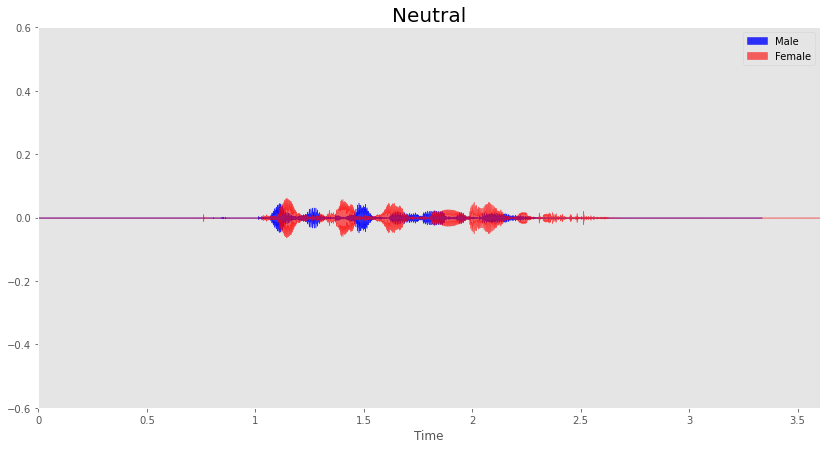

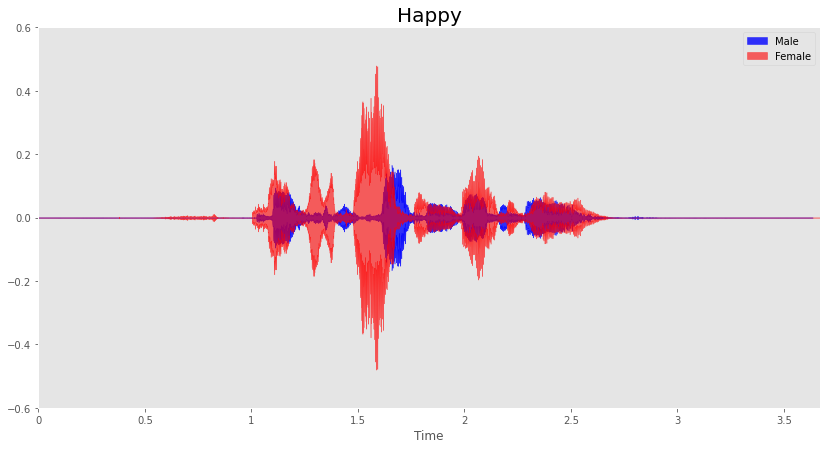

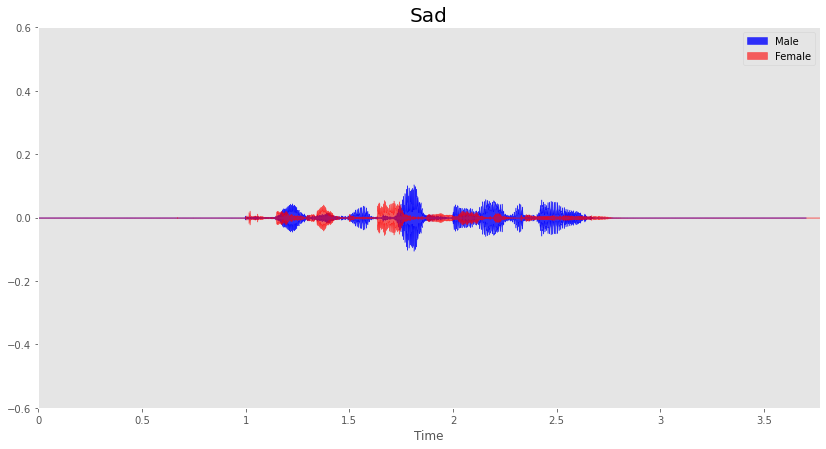

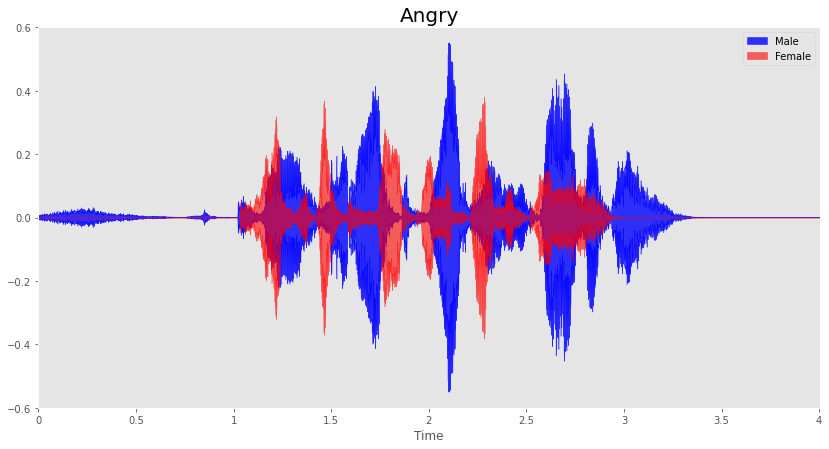

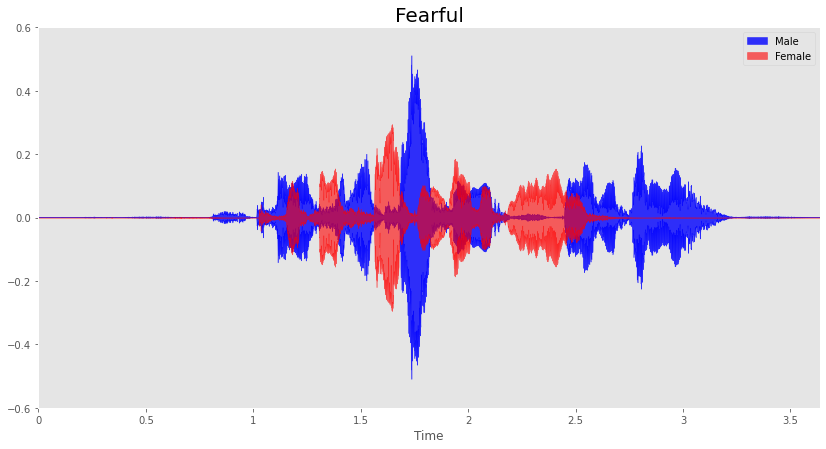

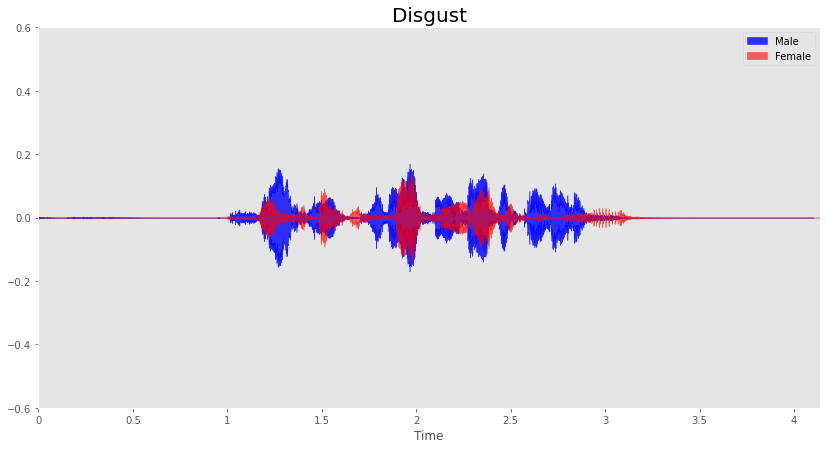

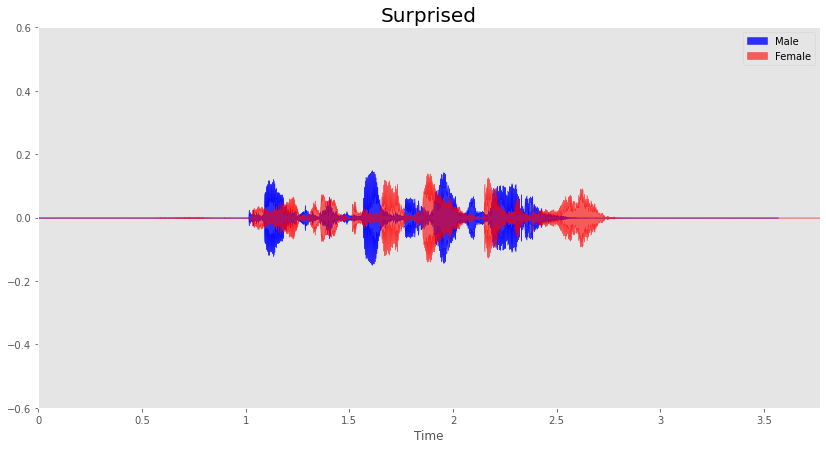

In [70]:
for emotion in list(male_dict.keys()):
    fig, ax = plt.subplots(figsize = (14,7))
    y, sr = librosa.load(male_dict[emotion])
    y1, sr1 = librosa.load(female_dict[emotion])
    ax = librosa.display.waveplot(y, alpha=0.8, label='Male', color='blue')
    ax = librosa.display.waveplot(y1, alpha=0.6, label='Female', color='red')
    plt.grid(visible = False)
    plt.legend()
    plt.title(emotion.title(), fontsize = 20)
    plt.ylim(bottom=-.6, top=.6)